In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

### 1. The dataset - Correlations

Dataset source : https://www.kaggle.com/mohansacharya/graduate-admissions

In [2]:
df = pd.read_csv('Admission_Predict.csv', delimiter =',', encoding='latin-1')
df = pd.DataFrame(df)
df.shape

(400, 9)

In [3]:
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


#### Correlations

<IPython.core.display.Javascript object>


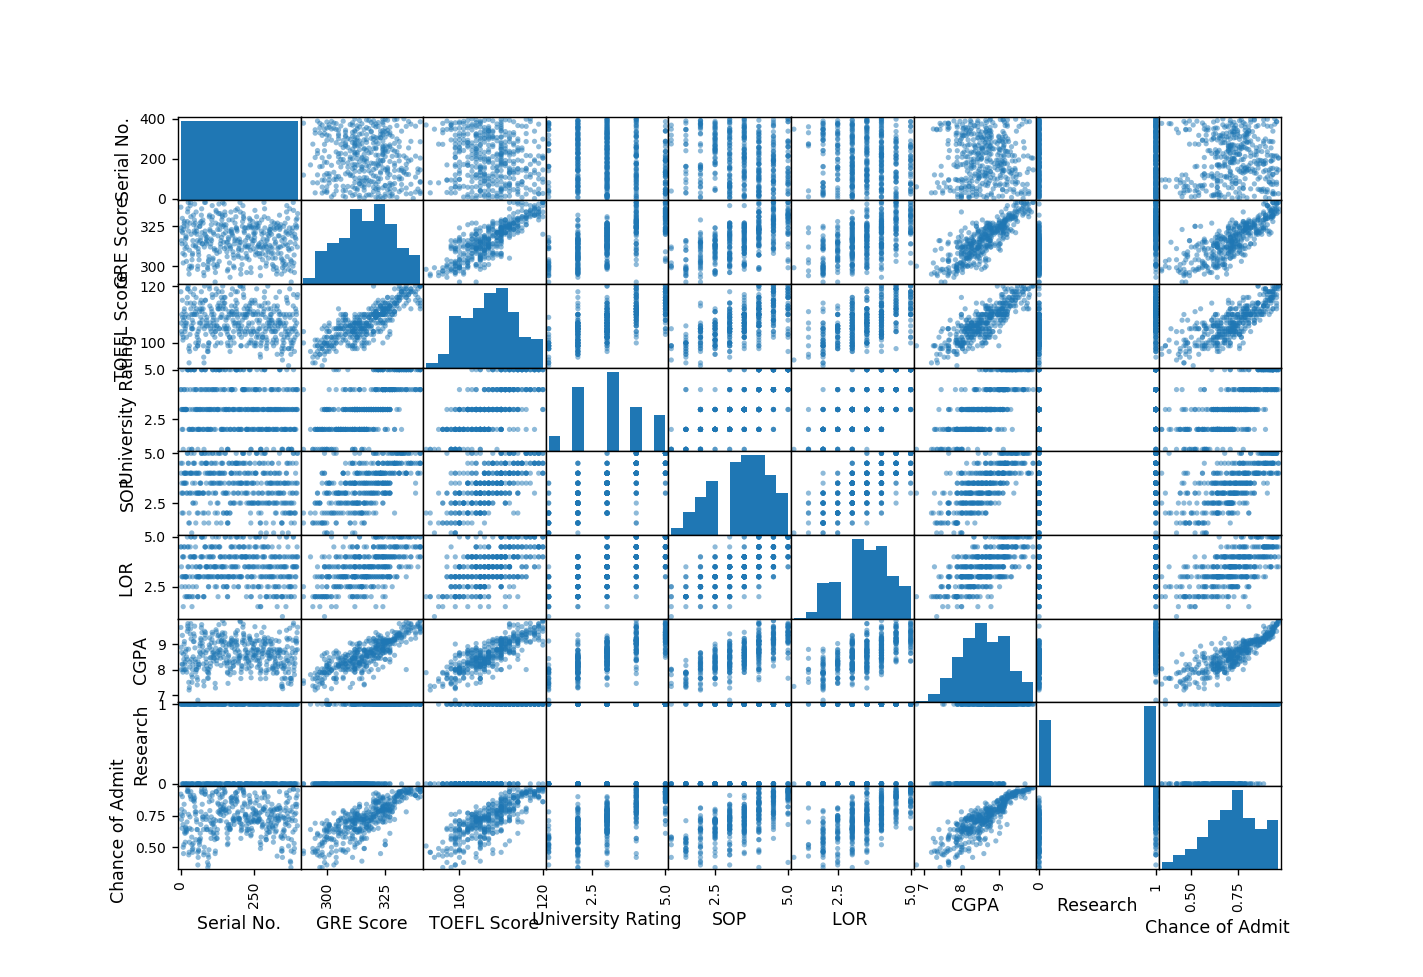

In [41]:
%matplotlib notebook
scatter_matrix(df, figsize=(20,12)) ;

#### Remark 1

Looking at the correlation chart we see that all variables, except for "Serial No.", have some impact on "Chance of Admit" variable. Variables like "GRE Score", "TOEFL Score" and "CGPA" are highly correlated to "Chance of Admit", while the rest not so much.

One could also draw the "correlation heatmap" to see this (use the "seaborn.heatmap" method)

#### Remark 2

We also observe that the variables "GRE Score", "TOEFL Score" and "CGPA" are highly correlated with each other.

In odrer to treat this multicollinearity issue in linear regression one usually resorts to Ridge regression instead of the classical OLS regression. Ridge regression performs slightly worse on the training set but better on the test set. At the same time, the distance between the training and test performance is smaller when compared to the OLS regressor. 

#### Defining the data variables

In [5]:
X = df.drop(df.iloc[:, [0,-1]], axis=1) # all columns except for the first and the last one
y = df[df.columns[-1]]  # targets

In [6]:
X_train, X_test, y_train, y_test = train_test_split (X,y, test_size = 0.1 , random_state = 0)

In [7]:
X_train.shape

(360, 7)

### 2. RNN Regressor

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold

#### preparing the data to feed them into the network

In [9]:
X_train_rnn = np.reshape( X_train.values, (X_train.values.shape[0],1,X_train.values.shape[1]) )
X_test_rnn = np.reshape( X_test.values,  (X_test.values.shape[0],1,X_test.values.shape[1]) )

In [10]:
y_train_rnn = y_train.values
y_test_rnn = y_test.values

#### hyperparameters tuning

In [ ]:
best_score = 1

for rnn_units in [512,256,128,64]:
    for hidden_dense_layers in [1,2]:
        for dense_units in [64,32,16,8]:
            for act_fct in ['linear', 'tanh', 'sigmoid']:
                
                model_scores = []
                
                kf = KFold(n_splits=5, random_state=None, shuffle=False)
                cross_val_indices = kf.split(X_train_rnn)

                for tr_index, val_index in cross_val_indices:

                    X_tr, X_val = X_train_rnn[tr_index], X_train_rnn[val_index]
                    y_tr, y_val = y_train_rnn[tr_index], y_train_rnn[val_index]
                
                    model = Sequential()
                    # input layer
                    model.add(SimpleRNN(units = rnn_units, return_sequences=True, input_shape = (1,X_train_rnn.shape[2]) )) 
                    # hidden dense layers
                    if hidden_dense_layers == 1:
                        model.add(Dense(dense_units, activation = act_fct))
                    if hidden_dense_layers == 2:
                        model.add(Dense(dense_units, activation = act_fct))
                        model.add(Dense(dense_units, activation = act_fct))
                    # output layer
                    model.add(Dense(1, activation = 'linear'))

                    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

                    early_stopping = EarlyStopping(monitor='val_loss', min_delta= 0.001, patience=7, verbose=0, mode='auto')
                    
                    h=model.fit(X_tr, y_tr, epochs = 50, batch_size = 32,validation_data=(X_val, y_val), callbacks = [early_stopping] ) 
                    
                    #print(h.history['val_loss'][-1])
                    model_scores = np.append( model_scores, h.history['val_loss'][-1])

                # mean model score
                mean_model_score = np.mean(model_scores)
                
                if mean_model_score < best_score :
                    best_score = mean_model_score
                    opt_parameters = {'rnn_units' : rnn_units, 'hidden_dense_layers' : hidden_dense_layers,'dense_units' : dense_units, 'activation_function' : act_fct}

NOTE !!! The output of the cell above contains all the training results per epoch of all the trained networks used in the tuning procedure.
In the interest of space I chose to clear the output after running the cell.


In [43]:
print('The final RNN regressor is the one with ', opt_parameters)

The final RNN regressor is the one with  {'rnn_units': 512, 'hidden_dense_layers': 2, 'dense_units': 32, 'activation_function': 'linear'}


#### the final model

In [13]:
final_model = Sequential()
final_model.add(SimpleRNN(units = opt_parameters['rnn_units'], return_sequences=True, input_shape = (1,X_train_rnn.shape[2]) ))
final_model.add(Dense(opt_parameters['dense_units'], activation = opt_parameters['activation_function'] ))
final_model.add(Dense(1, activation = 'linear' ))
final_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
h = final_model.fit(X_train_rnn, y_train_rnn, epochs = 50, batch_size = 32, validation_data=(X_test_rnn, y_test_rnn) ) 

NOTE !!! The output of the cell above contains all the training results per epoch of the final model. In the interest of space I chose to clear the output after running the cell.

#### plots of training and test loss

<IPython.core.display.Javascript object>


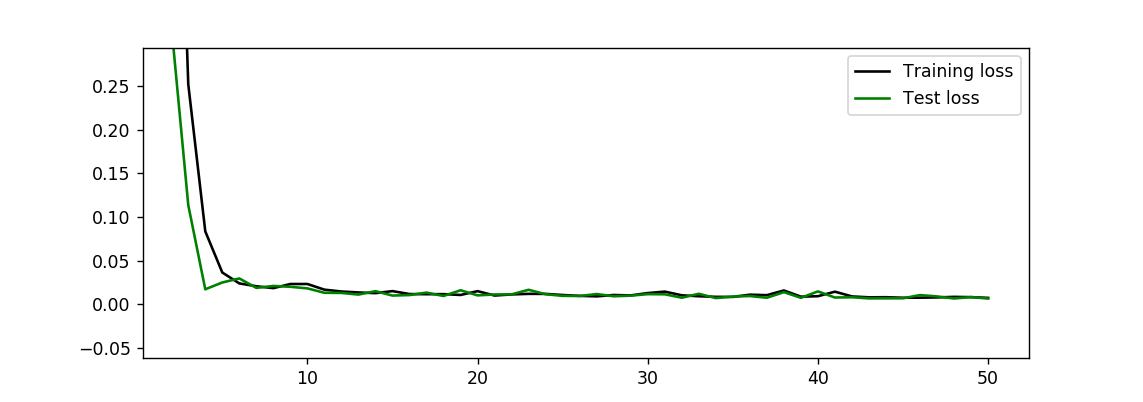

In [39]:
loss = h.history['loss']
test_loss = h.history['val_loss']

%matplotlib notebook

epochs = range(1, len(loss)+1)
plt.plot(epochs, loss,'black', label='Training loss')
plt.plot(epochs, test_loss, 'green', label='Test loss')
plt.legend()
plt.show()

### 3. Linear OLS Regressor

In [16]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### 4.Linear Ridge Regressor

In [17]:
from sklearn.linear_model import Ridge

#### hyperparameters tuning

In [18]:
best_score = 0

alphas = [0.01, 0.1, 0.5, 0.75, 1, 1.5, 2, 5, 10]

for alpha in alphas : 
    
    rid = Ridge(alpha)
    score = cross_val_score(rid, X_train, y_train, cv = 5)
    score = np.mean(score)
    
    if score > best_score :
        best_score = score
        best_parameters = {'alpha' : alpha}

print('The final Ridge regressor is the one with ', best_parameters)

The final Ridge regressor is the one with  {'alpha': 1}


#### the final model

In [19]:
f_ridge = Ridge(alpha = best_parameters['alpha'])
f_ridge.fit(X_train, y_train)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

#### RMK : OLS vs Ridge

In [20]:
# recall that the "score" method computes the coefficient of determination R^2

# scores on train set
print(f_ridge.score(X_train, y_train), lin_reg.score(X_train, y_train))

# scores on test set
print(f_ridge.score(X_test, y_test), lin_reg.score(X_test, y_test))

0.8108420166857344 0.8109138281216663
0.727577588526449 0.7269217798651046


From the results above we see that "Remark 2" given in the begining is verified.

In other words, indeed the ridge regressor is a slightly worse fit to the training data BUT understands unseen data slighlty better.

### 5. k-Neighbors Regressor

In [21]:
from sklearn.neighbors import KNeighborsRegressor

#### hyperparameters tuning

In [22]:
best_score = 0

metrics =  ['minkowski','chebyshev','manhattan','cosine']
neighbors = np.arange(1,36)

for metric in metrics :

    for n_neighbors in neighbors :  
        
        k_reg = KNeighborsRegressor(n_neighbors = n_neighbors, metric = metric) 
        score = cross_val_score(k_reg, X_train, y_train, cv=5)
        score = np.mean(score)
        
        if score > best_score :
            best_score = score
            best_parameters = {'n_neighbors' : n_neighbors,'metric' : metric}

print('The final Nearest Neighbors model is the one with ', best_parameters)

The final Nearest Neighbors model is the one with  {'n_neighbors': 10, 'metric': 'manhattan'}


#### the final model

In [23]:
f_NearNeigh = KNeighborsRegressor(n_neighbors = best_parameters['n_neighbors'], metric = best_parameters['metric'])
f_NearNeigh.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='manhattan',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='uniform')

### 6. Summary / Models comparisons

We will compare ALL final regressors using the MSE, which is a measure describing by how much on average a model fails to predict the correct values.

In [33]:
test_set_MSEs = {'Rnn regressor ' : rnn_test_set_mse,
                'OLS regressor ' : lin_reg_test_set_mse,
                'Ridge regressor ' : ridge_test_set_mse,
                'NN regressor ' : Near_Neigh_test_set_mse}

In [34]:
test_set_MSEs

{'Rnn regressor ': 0.006493577547371387,
 'OLS regressor ': 0.00529054916733843,
 'Ridge regressor ': 0.005277843694285708,
 'NN regressor ': 0.0056662000000000014}

Observe that the OLS regressor performs slighlty worse than the Ridge one. This means that in this context the multicollinearity among the "GRE Score", "TOEFL Score" and "CGPA" does not affect much the final result.

In [42]:
print('Overall, we see that the regressor which performs better on the unseen data of the test set is the ', 
      min(test_set_MSEs, key=test_set_MSEs.get) )

Overall, we see that the regressor which performs better on the unseen data of the test set is the  Ridge regressor 


### 7. Additional approaches for future repos

- Build decision trees and SVM regressors

- Perform PCA in order to transfer your features in a space with uncorrelated features.